Se aplicará un algoritmo de regresión líneal para predecir el número de streams de canciones de Spotify.

Primero, importaré las bibliotecas que considero necesarias, así como el dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')

ruta_archivo = '/content/drive/MyDrive/spotify-2023.csv'
df = pd.read_csv(ruta_archivo, encoding='latin-1')
print(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                              track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952          

Ahora que tengo el dataset hay que limpiarlo y entender la información que contiene

In [3]:
df_sin_dups = df.drop_duplicates() #Elimina los duplicados

df_sin_dups.isnull().sum() #Cuenta los valores nulos

df_sin_dups.dropna(inplace=True) #Reemplaza los valores nulos

df_sin_dups.info() #Imprime las columnas y su tipo de dato
df_sin_dups.head() #Imprime las primeras filas de cada columna

                              track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     released_year  released_month  released_day  in_spotify_pl

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


La parte anterior del código me permite visualizar la información del dataset, el tipo de dato que maneja cada columna.

Describiré cada columna
0.  Nombre de la canción
1.   Nombres de los artistas
2.  Numero de artistas que participan
3.  Año de lanzamiento
4. Mes de lanzamiento
5. Día de lanzamiento
6. Número de playlists en las que se encuentra la canción en spotify
7. Posición en la lista de éxitos de spotify
8. Streams
9. Número de playlists en las que se encuentra la canción en apple
10. Posición en la lista de éxitos de apple.
11. Número de playlists en las que se encuentra la canción en deezer
12. Posición en la lista de éxitos de deezer.
13. Posición en la lista de éxitos de shazam, o las más 'Shazameadas'
14. Pulsos por minuto. Mayor el número, más rápida o "movida" es la canción.
15. Porcentaje de "bailabilidad"
16. Porcentaje de "alegría" de la canción. 0 es lo más triste y 1 lo más feliz.
17. Porcentaje de energía de la canción
18. Porcentaje de acústica de la canción.
19. Porcentaje de instrumental en la canción.
20. Porcentaje de "en vivo" de la canción, o cuanto tiempo se canta.
21. Porcentaje de silencio del vocalista.

Como se ve en la información, streams es de tipo de dato object, por lo que aplicaré una limpieza a estos datos

In [4]:
df_sin_dups['streams'] = df_sin_dups['streams'].str.replace(',', '', regex=True) # Eliminar comas
df_sin_dups['streams'] = pd.to_numeric(df['streams'], errors='coerce') #Convertir a numerico, los errores se convierten en NaN
df_sin_dups.dropna(subset=['streams'], inplace=True) #Eliminar los NaN de streams

Ahora que ya sé que significa cada dato y puedo trabajar con streams, voy a ver cómo se relacionan las variables

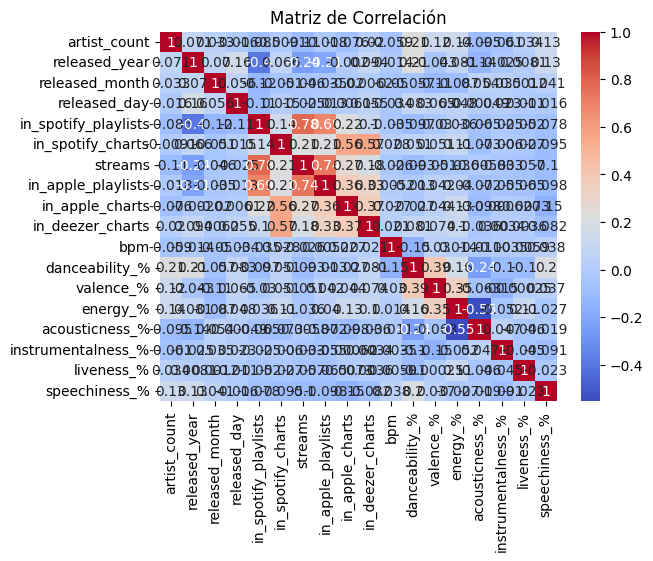

In [5]:
correlation_matrix = df_sin_dups.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

Observo que las variables con una relación fuerte con 'streams' son 'in_spotify_playlists', 'in_spotify_charts' y 'in_apple_playlists', por lo que esas serán mis variables predictoras y entrenaré el modelo

In [9]:
X = df_sin_dups[['in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists']]
y = df_sin_dups['streams']
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar solo las variables numéricas
scaler = StandardScaler()

# Identificar las columnas numéricas para escalar
numerical_cols = X.select_dtypes(include=['number']).columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols]) # Ajustar y transformar en entrenamiento
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) # Solo transformar en prueba

# Entrenar modelo con LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Ahora veré cómo predice el modelo, poniendo valores arbitrarios a las variables predictoras

In [12]:
# Define nuevo_dato con 3 valores
nuevo_dato = np.array([[100,30,80]]) # Ejemplo de valor para 'in_spotify_playlists', 'in_spotify_charts' y 'in_apple_playlists'

# Selecciona las columnas numéricas del nuevo dato para escalar
nuevo_dato_numericas = nuevo_dato[:, :len(numerical_cols)]

# Escala los datos numéricos del nuevo dato
nuevo_dato[:, :len(numerical_cols)] = scaler.transform(nuevo_dato_numericas)

prediccion = model.predict(nuevo_dato)
print(f"Predicción para el nuevo dato: {prediccion}")

Predicción para el nuevo dato: [4.58769198e+08]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


La predicción es de 458 millones de streams. Aunque suene una cantidad enorme, comparando con Cruel Summer de Taylor swift, que tiene 800 millones de streams, vemos que la escala de la predicción está bien.

Ahora, solo resta hacer la evaluación del modelo

RMSE con LinearRegression: 283353412.8677556
R-cuadrado con LinearRegression: 0.7381492526816057


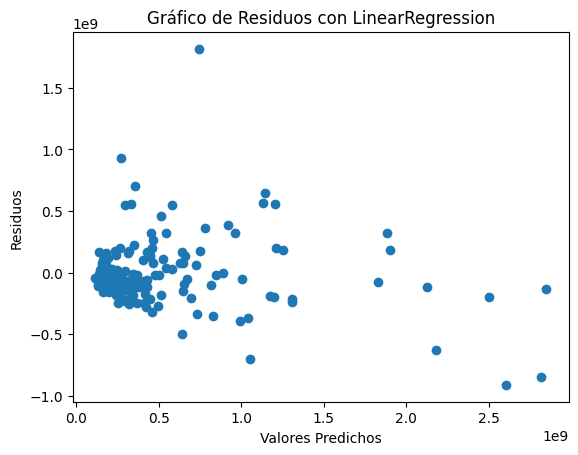

In [15]:
# Evaluar el modelo
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = model.score(X_test, y_test)
print(f'RMSE con LinearRegression: {rmse}')
print(f'R-cuadrado con LinearRegression: {r2}')

#Graficar residuos
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos con LinearRegression")
plt.show()

Vemos que el RMSE está en la escala de cientos de millones, que está en nuestro rango de valores de streams de cientos y miles de millones, por lo que lo tomaré por aceptable, al igual que el valor de R-cuadrado, que explica el 73.81% de la variabilidad de los streams. La gráfica de residuos muestra que el modelo predice con mayor frecuencia valores de streams más bajos.